In [ ]:
# @title Install dependencies
!pip install rarfile --quiet
!pip install ale-py --quiet
!pip install 'stable-baselines3[extra]' --quiet
!pip install -q gymnasium --quiet
!pip install swig --quiet
!pip install pyvirtualdisplay --quiet
!pip install pyglet --quiet
!pip install pygame --quiet
!pip install minigrid --quiet
!pip install -q swig --quiet
!pip install minigrid --quiet
!pip3 install box2d-py --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.7/136.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.5/374.5 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
# Imports
import io
import os
import glob
import torch
import base64
import minigrid

import numpy as np
import matplotlib.pyplot as plt

import sys
import gymnasium

import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env

import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.box2d.lunar_lander import *
from gymnasium.wrappers import RecordVideo
from ale_py import ALEInterface

import warnings
warnings.filterwarnings('ignore')

ale = ALEInterface()

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyPacked has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type SwigPyObject has no __module__ attribute
<frozen importlib._bootstrap>:488: DeprecationWarning: builtin type swigvarlink has no __module__ attribute


In [ ]:
# @title Play Video function
from IPython.display import HTML
from base64 import b64encode
from pyvirtualdisplay import Display

# create the directory to store the video(s)
os.makedirs("./video", exist_ok=True)

display = Display(visible=False, size=(1400, 900))
_ = display.start()


def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video
  at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [ ]:
nn_layers = [64, 64]


learning_rate = 0.001

Now, let us setup our model and the DQN algorithm.

In [ ]:
log_dir = "/tmp/gym/"
os.makedirs(log_dir, exist_ok=True)

# Create environment
env_name = 'LunarLander-v3'
env = gym.make(env_name)
# You can also load other environments like cartpole, MountainCar, Acrobot.
# Refer to https://gym.openai.com/docs/ for descriptions.

# For example, if you would like to load Cartpole,
# just replace the above statement with "env = gym.make('CartPole-v1')".

env = stable_baselines3.common.monitor.Monitor(env, log_dir )

callback = EvalCallback(env, log_path=log_dir, deterministic=True)  
policy_kwargs = dict(activation_fn=torch.nn.ReLU,
                     net_arch=nn_layers)
model = DQN("MlpPolicy", env,policy_kwargs = policy_kwargs,
            learning_rate=learning_rate,
            batch_size=1, 
            buffer_size=1, 
            learning_starts=1, 
            gamma=0.99, 
            tau = 1,  
            target_update_interval=1,  
            train_freq=(1,"step"), 
            max_grad_norm = 10, 
            exploration_initial_eps = 1,  
            exploration_fraction = 0.5,  
            gradient_steps = 1,  
            seed = 1,  
            verbose=0)  


Before we train the model, let us look at an instance of Lunar Lander **before training**.  


In [ ]:
env_name = 'LunarLander-v3'
env = gym.make(env_name)
print('State shape: ', env.observation_space.shape)
print('Number of actions: ', env.action_space.n)

State shape:  (8,)
Number of actions:  4


In [ ]:
env = gym.make(env_name, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(
    env,
    video_folder="video",
    name_prefix=f"{env_name}_pretraining",
    episode_trigger=lambda episode_id: True
)

observation, _ = env.reset()
total_reward = 0
done = False

while not done:
    action, states = model.predict(observation, deterministic=True)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward

env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_pretraining-episode-0.mp4")
HTML(html)


Total reward: -365.80812046776146


In [ ]:
model.learn(total_timesteps=100000, log_interval=10, callback=callback)


Eval num_timesteps=10000, episode_reward=-316.03 +/- 96.76
Episode length: 87.40 +/- 8.11
New best mean reward!
Eval num_timesteps=20000, episode_reward=-72.12 +/- 28.46
Episode length: 88.20 +/- 3.87
New best mean reward!
Eval num_timesteps=30000, episode_reward=-464.56 +/- 68.66
Episode length: 156.40 +/- 48.96
Eval num_timesteps=40000, episode_reward=-252.16 +/- 13.86
Episode length: 595.80 +/- 114.32
Eval num_timesteps=50000, episode_reward=-27.78 +/- 83.38
Episode length: 894.00 +/- 130.32
New best mean reward!
Eval num_timesteps=60000, episode_reward=-67.35 +/- 103.69
Episode length: 441.60 +/- 75.51
Eval num_timesteps=70000, episode_reward=-154.81 +/- 74.24
Episode length: 485.20 +/- 310.82
Eval num_timesteps=80000, episode_reward=-100.42 +/- 40.64
Episode length: 844.20 +/- 200.15
Eval num_timesteps=90000, episode_reward=-40.68 +/- 17.53
Episode length: 1000.00 +/- 0.00
Eval num_timesteps=100000, episode_reward=137.78 +/- 96.34
Episode length: 275.40 +/- 185.90
New best mean re

In [ ]:
env = gym.make(env_name, render_mode="rgb_array")
env = gym.wrappers.RecordVideo(
    env,
    video_folder="video",
    name_prefix=f"{env_name}_learned",
    episode_trigger=lambda episode_id: True
)

observation, _ = env.reset()
total_reward = 0
done = False

while not done:
    action, states = model.predict(observation, deterministic=True)
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    total_reward += reward

env.close()
print(f"\nTotal reward: {total_reward}")

# show video
html = render_mp4(f"video/{env_name}_learned-episode-0.mp4")
HTML(html)


Total reward: 229.20886415296263


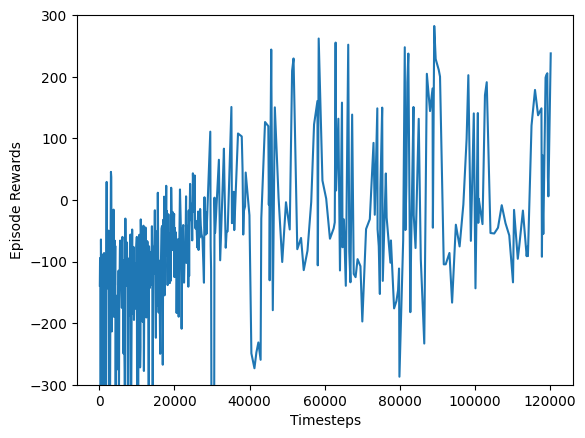

In [ ]:
x, y = ts2xy(load_results(log_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting.
plt.plot(x, y)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.show()

In [ ]:
exploration_initial_eps = 1  # initial value of random action probability. Range is between 0 and 1.
exploration_fraction = 0.5  # fraction of entire training period over which the exploration rate is reduced. Range is between 0 and 1.
exploration_final_eps = 0.05  # (set by defualt) final value of random action probability. Range is between 0 and 1.

--- Starting Training for exploration_fraction = 0.1 ---
Eval num_timesteps=10000, episode_reward=-262.72 +/- 23.36
Episode length: 198.20 +/- 43.90
New best mean reward!
Eval num_timesteps=20000, episode_reward=-81.04 +/- 30.97
Episode length: 956.40 +/- 87.20
New best mean reward!
Eval num_timesteps=30000, episode_reward=-104.58 +/- 62.80
Episode length: 872.00 +/- 164.54
Eval num_timesteps=40000, episode_reward=-94.55 +/- 20.50
Episode length: 902.40 +/- 195.20
Eval num_timesteps=50000, episode_reward=-137.80 +/- 31.66
Episode length: 77.40 +/- 7.99
Eval num_timesteps=60000, episode_reward=-88.98 +/- 14.69
Episode length: 164.40 +/- 46.69
Eval num_timesteps=70000, episode_reward=103.15 +/- 131.42
Episode length: 506.40 +/- 163.79
New best mean reward!
Eval num_timesteps=80000, episode_reward=101.46 +/- 119.61
Episode length: 203.40 +/- 45.99
Eval num_timesteps=90000, episode_reward=181.33 +/- 109.04
Episode length: 333.60 +/- 21.28
New best mean reward!
Eval num_timesteps=100000, ep

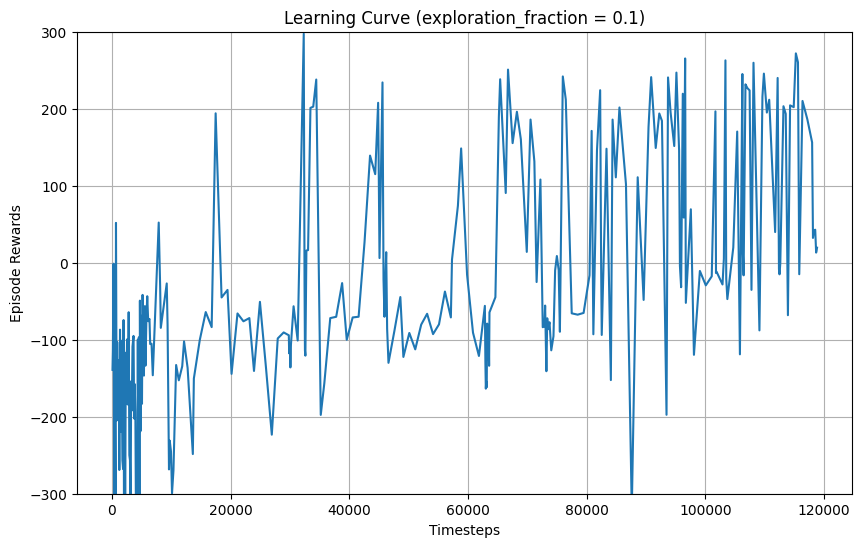

In [ ]:
# SCRIPT 1: EXPLORATION-EXPLOITATION EXPERIMENT

import os
import gymnasium as gym
import torch
import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
import matplotlib.pyplot as plt
import numpy as np


EXPLORATION_FRACTION = 0.1

log_dir = f"./tmp/gym_exploration_{EXPLORATION_FRACTION}/"
os.makedirs(log_dir, exist_ok=True)

env = gym.make('LunarLander-v3')
env = Monitor(env, log_dir)

callback = EvalCallback(env, log_path=log_dir, deterministic=True)


nn_layers = [64, 64]
learning_rate = 0.001

policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=nn_layers)

model = DQN(
    "MlpPolicy",
    env,
    policy_kwargs=policy_kwargs,
    learning_rate=learning_rate,
    batch_size=1,
    buffer_size=1,
    learning_starts=1,
    gamma=0.99,
    tau=1,
    target_update_interval=1,
    train_freq=(1, "step"),
    max_grad_norm=10,
    exploration_initial_eps=1,
    exploration_fraction=EXPLORATION_FRACTION,  # This is the key parameter we are changing
    gradient_steps=1,
    seed=1,
    verbose=0
)

print(f"--- Starting Training for exploration_fraction = {EXPLORATION_FRACTION} ---")
model.learn(total_timesteps=100000, log_interval=10, callback=callback)
print("--- Training Complete ---")

x, y = ts2xy(load_results(log_dir), 'timesteps')
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.title(f'Learning Curve (exploration_fraction = {EXPLORATION_FRACTION})')
plt.grid(True)
plt.show()

env.close()

As you are only changing the reward structure, you can inherit the [original Lunar Lander environment](https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py) and modify just the "step" function. Focus on modifying the following part of the code in the "step" function.

--- Starting Training with Shaped Reward ---
Eval num_timesteps=10000, episode_reward=-891.85 +/- 995.72
Episode length: 2688.40 +/- 3083.00
New best mean reward!
Eval num_timesteps=20000, episode_reward=-63.16 +/- 154.45
Episode length: 418.40 +/- 108.60
New best mean reward!
Eval num_timesteps=30000, episode_reward=-212.03 +/- 166.75
Episode length: 1477.60 +/- 2232.18
Eval num_timesteps=40000, episode_reward=-1000.82 +/- 1402.97
Episode length: 4368.40 +/- 4881.07
Eval num_timesteps=50000, episode_reward=-497.39 +/- 971.40
Episode length: 2477.00 +/- 3805.92
Eval num_timesteps=60000, episode_reward=-2485.37 +/- 889.63
Episode length: 6344.20 +/- 3025.00
Eval num_timesteps=70000, episode_reward=-1632.36 +/- 540.56
Episode length: 4398.20 +/- 1894.97
Eval num_timesteps=80000, episode_reward=-965.13 +/- 491.83
Episode length: 1992.00 +/- 1280.55
Eval num_timesteps=90000, episode_reward=-981.85 +/- 406.38
Episode length: 2216.00 +/- 1297.29
Eval num_timesteps=100000, episode_reward=-143

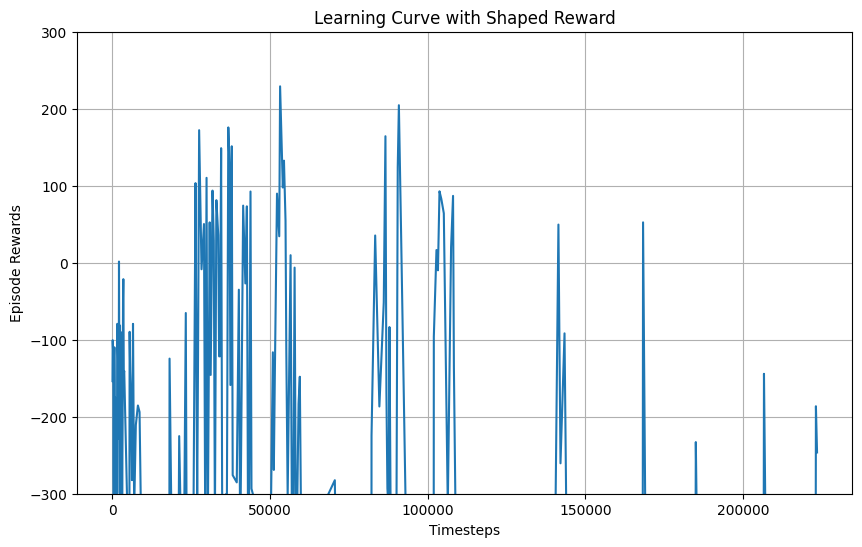

In [ ]:
# SCRIPT 2: REWARD SHAPING EXPERIMENT

import os
import gymnasium as gym
from gymnasium.envs.box2d.lunar_lander import LunarLander
import torch
import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
import matplotlib.pyplot as plt
import numpy as np

class ShapedRewardLander(LunarLander):
    def __init__(self, **kwargs):
        super(ShapedRewardLander, self).__init__(**kwargs)

    def step(self, action):
        state, reward, terminated, truncated, info = super().step(action)


        center_penalty = -abs(state[0]) * 0.5

        # Penalty for having a large angle (not being upright)
        angle_penalty = -abs(state[4]) * 0.5

        # Add our custom penalties to the original reward
        shaped_reward = reward + center_penalty + angle_penalty

        return state, shaped_reward, terminated, truncated, info

log_dir = "./tmp/gym_reward_shaping/"
os.makedirs(log_dir, exist_ok=True)

env = ShapedRewardLander()
env = Monitor(env, log_dir)

callback = EvalCallback(env, log_path=log_dir, deterministic=True)

nn_layers = [64, 64]
learning_rate = 0.001
policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=nn_layers)

model = DQN("MlpPolicy", env, policy_kwargs=policy_kwargs, learning_rate=learning_rate, seed=1, verbose=0)

print("--- Starting Training with Shaped Reward ---")
model.learn(total_timesteps=100000, log_interval=10, callback=callback)
print("--- Training Complete ---")

x, y = ts2xy(load_results(log_dir), 'timesteps')
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.title('Learning Curve with Shaped Reward')
plt.grid(True)
plt.show()

env.close()

--- Starting Training with Masked State (No Angular Velocity) ---
Eval num_timesteps=10000, episode_reward=-19.13 +/- 200.95
Episode length: 742.60 +/- 497.19
New best mean reward!
Eval num_timesteps=20000, episode_reward=-25.72 +/- 67.51
Episode length: 506.00 +/- 222.96
Eval num_timesteps=30000, episode_reward=-90.33 +/- 147.04
Episode length: 386.20 +/- 70.50
Eval num_timesteps=40000, episode_reward=-110.52 +/- 175.29
Episode length: 316.80 +/- 52.18
Eval num_timesteps=50000, episode_reward=-24.10 +/- 141.72
Episode length: 305.60 +/- 42.00
Eval num_timesteps=60000, episode_reward=-142.16 +/- 76.87
Episode length: 216.80 +/- 35.68
Eval num_timesteps=70000, episode_reward=-121.43 +/- 100.99
Episode length: 301.20 +/- 78.12
Eval num_timesteps=80000, episode_reward=-2916.21 +/- 5962.15
Episode length: 100488.20 +/- 200427.42
Eval num_timesteps=90000, episode_reward=-44.80 +/- 166.10
Episode length: 330.40 +/- 245.07
Eval num_timesteps=100000, episode_reward=-134.84 +/- 64.64
Episode le

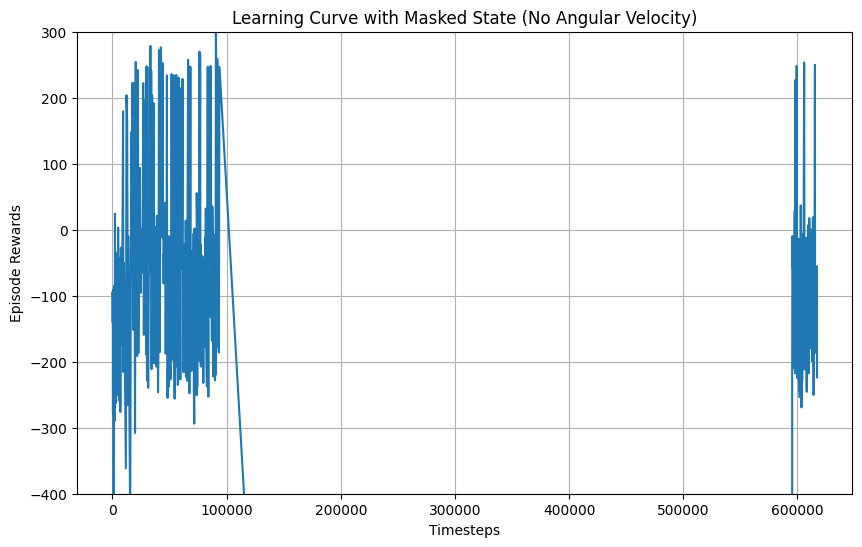

In [ ]:
# SCRIPT 3: STATE ABLATION EXPERIMENT

import os
import gymnasium as gym
from gymnasium import spaces
from gymnasium.envs.box2d.lunar_lander import LunarLander
import torch
import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
import matplotlib.pyplot as plt
import numpy as np

class MaskedStateLander(LunarLander):
    def __init__(self, **kwargs):
        super(MaskedStateLander, self).__init__(**kwargs)
        high = self.observation_space.high
        low = self.observation_space.low
        low[5], high[5] = 0.0, 0.0
        self.observation_space = spaces.Box(low, high, dtype=np.float32)

    def step(self, action):
        state, reward, terminated, truncated, info = super().step(action)
        state[5] = 0.0
        return state, reward, terminated, truncated, info

log_dir = "./tmp/gym_masked_state/"
os.makedirs(log_dir, exist_ok=True)

env = MaskedStateLander()
env = Monitor(env, log_dir)

callback = EvalCallback(env, log_path=log_dir, deterministic=True)

nn_layers = [64, 64]
learning_rate = 0.001
policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=nn_layers)

model = DQN("MlpPolicy", env, policy_kwargs=policy_kwargs, learning_rate=learning_rate, seed=1, verbose=0)

print("--- Starting Training with Masked State (No Angular Velocity) ---")
model.learn(total_timesteps=100000, log_interval=10, callback=callback)
print("--- Training Complete ---")

x, y = ts2xy(load_results(log_dir), 'timesteps')
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.ylim([-400, 300]) # Widen ylim as performance might be worse
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.title('Learning Curve with Masked State (No Angular Velocity)')
plt.grid(True)
plt.show()

env.close()

In [ ]:
# SCRIPT 5a: PRE-TRAINING THE BASE MODEL

import os
import gymnasium as gym
import torch
import stable_baselines3
from stable_baselines3 import DQN

env = gym.make('LunarLander-v3')
model_save_path = "./dqn_lunar_base_model.zip"

nn_layers = [64, 64]
learning_rate = 0.001
policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=nn_layers)

model = DQN("MlpPolicy", env, policy_kwargs=policy_kwargs, learning_rate=learning_rate, seed=1, verbose=1)

print("--- Starting Pre-training on original Lunar Lander ---")
model.learn(total_timesteps=100000)

model.save(model_save_path)
print(f"--- Pre-training Complete. Model saved to {model_save_path} ---")

env.close()

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
--- Starting Pre-training on original Lunar Lander ---
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 84.8     |
|    ep_rew_mean      | -111     |
|    exploration_rate | 0.968    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1388     |
|    time_elapsed     | 0        |
|    total_timesteps  | 339      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.28     |
|    n_updates        | 59       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 87.4     |
|    ep_rew_mean      | -143     |
|    exploration_rate | 0.934    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1294     |
|    time_elapsed     | 0        |
|    total

--- Loading pre-trained model from ./dqn_lunar_base_model.zip ---
Wrapping the env in a DummyVecEnv.
--- Starting Fine-Tuning on Obstacle Lander Task ---
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 784      |
|    ep_rew_mean      | -72.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 190      |
|    fps              | 804      |
|    time_elapsed     | 7        |
|    total_timesteps  | 106343   |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.35     |
|    n_updates        | 26560    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 755      |
|    ep_rew_mean      | -85.9    |
|    exploration_rate | 0.05     |
| time/               |          |
|    episodes         | 200      |
|    fps              | 809      |
|    time_elapsed     | 10       |
|    t

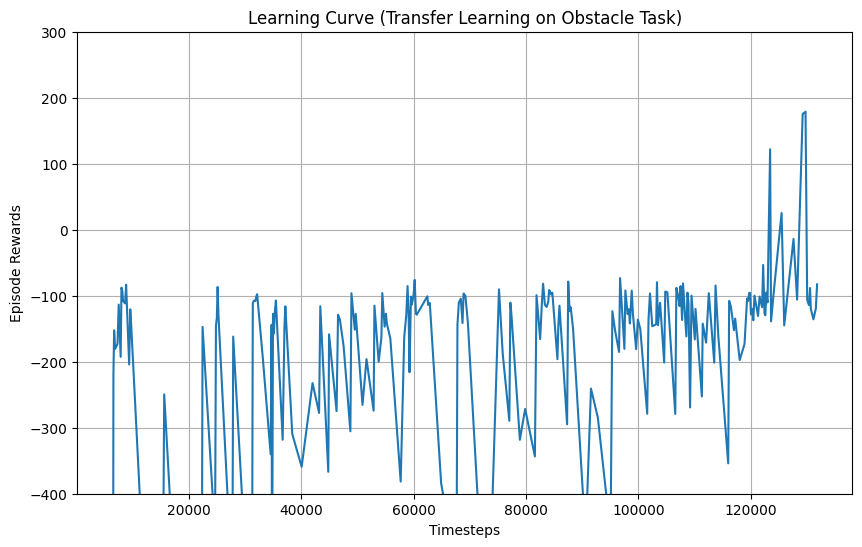

In [ ]:
# SCRIPT 5b: TRANSFER LEARNING ON OBSTACLE AVOIDANCE TASK

import os
import gymnasium as gym
from gymnasium.envs.box2d.lunar_lander import LunarLander
import torch
import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
import matplotlib.pyplot as plt
import numpy as np

class ObstacleLander(LunarLander):
    def __init__(self, **kwargs):
        super(ObstacleLander, self).__init__(**kwargs)
        self.obstacle_zone = [-0.3, 0.3, 0.3, 0.5]

    def step(self, action):
        state, reward, terminated, truncated, info = super().step(action)

        x_pos, y_pos = state[0], state[1]

        in_obstacle = (self.obstacle_zone[0] < x_pos < self.obstacle_zone[1] and
                       self.obstacle_zone[2] < y_pos < self.obstacle_zone[3])

        if in_obstacle:
            reward = -150
            terminated = True

        return state, reward, terminated, truncated, info

log_dir = "./tmp/gym_transfer_learning/"
os.makedirs(log_dir, exist_ok=True)
model_load_path = "./dqn_lunar_base_model.zip"

env = ObstacleLander()
env = Monitor(env, log_dir)

callback = EvalCallback(env, log_path=log_dir, deterministic=True)


print(f"--- Loading pre-trained model from {model_load_path} ---")
model = DQN.load(model_load_path, env=env)

print("--- Starting Fine-Tuning on Obstacle Lander Task ---")
model.learn(total_timesteps=100000, log_interval=10, callback=callback, reset_num_timesteps=False)
print("--- Fine-Tuning Complete ---")

x, y = ts2xy(load_results(log_dir), 'timesteps')
plt.figure(figsize=(10, 6))
plt.plot(x, y)
plt.ylim([-400, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.title('Learning Curve (Transfer Learning on Obstacle Task)')
plt.grid(True)
plt.show()

env.close()

--- Starting Training in ./tmp/gym_baseline/ ---
--- Training Complete ---
--- Starting Training in ./tmp/gym_reward_shaping/ ---
--- Training Complete ---

--- Evaluating Baseline Agent ---
--- Evaluating Shaped Reward Agent ---


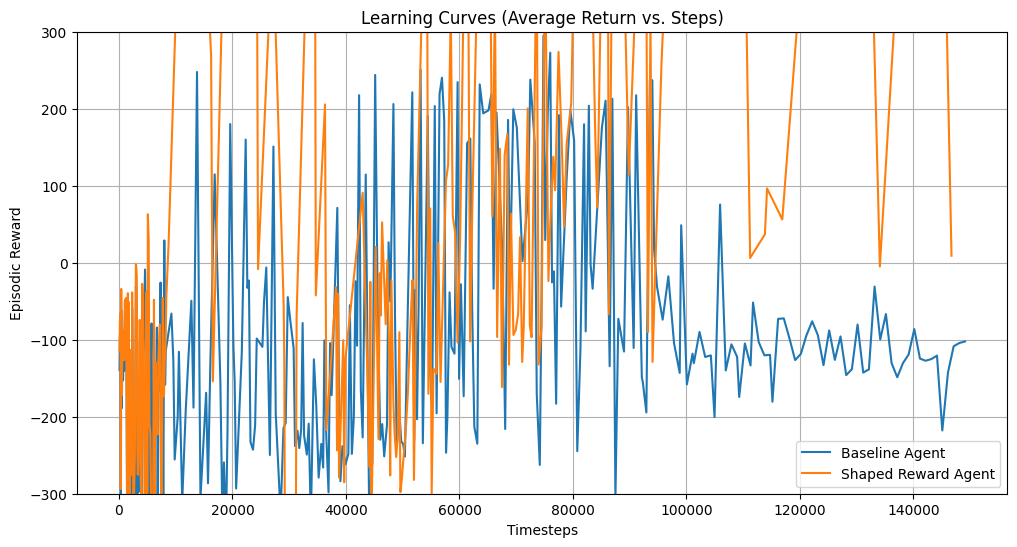

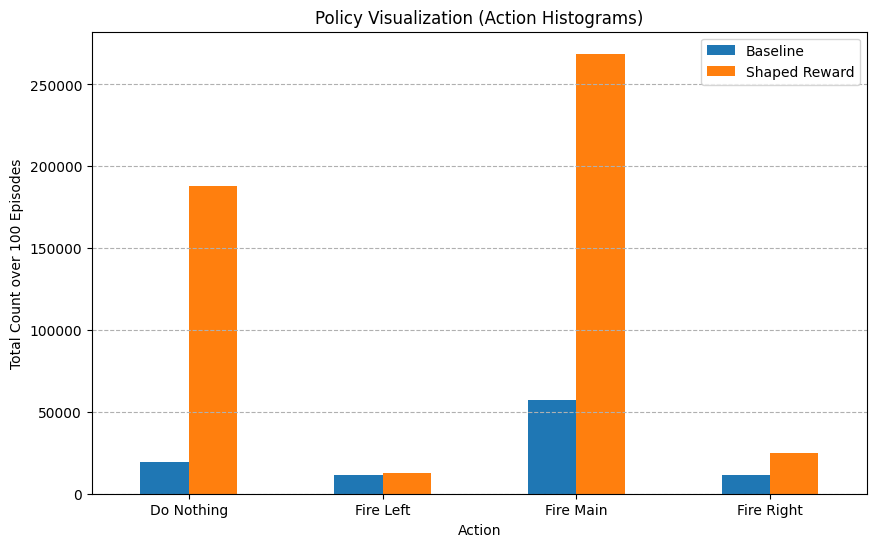

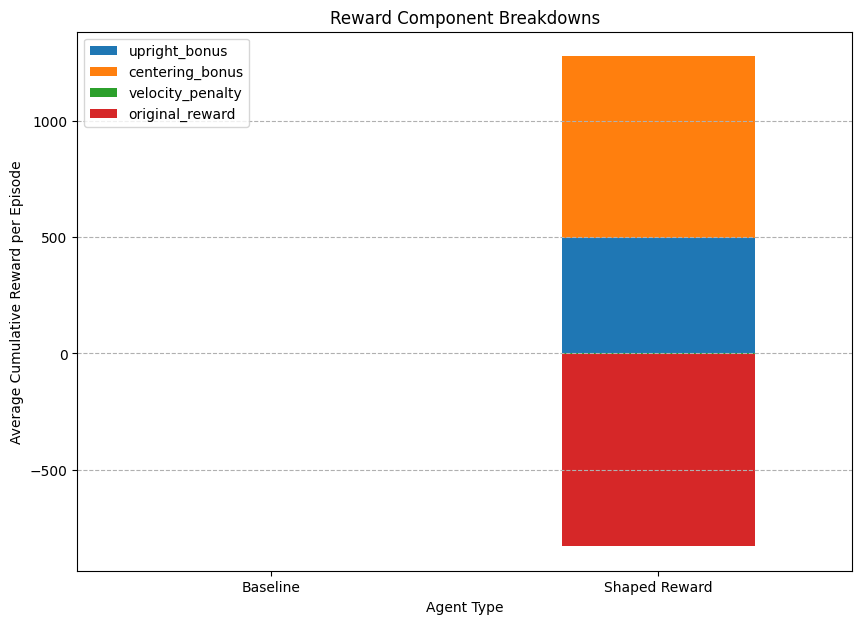

In [ ]:
# SCRIPT: REWARD SHAPING DESIGN, VISUALIZATION, AND ANALYSIS

import os
import gymnasium as gym
from gymnasium.envs.box2d.lunar_lander import LunarLander
import torch
import stable_baselines3
from stable_baselines3 import DQN
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# PART 1: DESIGN - Creating the Custom Environment
class ShapedRewardLander(LunarLander):
    def __init__(self, **kwargs):
        super(ShapedRewardLander, self).__init__(**kwargs)

    def step(self, action):
        original_state, original_reward, terminated, truncated, info = super().step(action)
        upright_bonus = 0
        centering_bonus = 0
        velocity_penalty = 0
        x_pos = original_state[0]
        y_pos = original_state[1]
        x_vel = original_state[2]
        y_vel = original_state[3]
        angle = original_state[4]
        upright_bonus = np.cos(angle) * 0.1
        centering_bonus = (1 / (abs(x_pos) + 0.1)) * 0.05

        velocity_penalty = - (x_vel**2 + y_vel**2) * 0.2

        shaped_reward = original_reward + upright_bonus + centering_bonus + velocity_penalty

        info['reward_components'] = {
            'original_reward': original_reward,
            'upright_bonus': upright_bonus,
            'centering_bonus': centering_bonus,
            'velocity_penalty': velocity_penalty
        }

        return original_state, shaped_reward, terminated, truncated, info

# PART 2: TRAINING & EVALUATION SETUP

def train_agent(env, log_dir_path):
    os.makedirs(log_dir_path, exist_ok=True)
    env = Monitor(env, log_dir_path)

    model = DQN("MlpPolicy", env, seed=1, verbose=0)
    print(f"--- Starting Training in {log_dir_path} ---")
    model.learn(total_timesteps=150000)
    print("--- Training Complete ---")
    model.save(f"{log_dir_path}/final_model.zip")
    return model

def evaluate_agent(env, model_path, num_episodes=100):
    model = DQN.load(model_path, env=env)
    action_counts = {0: 0, 1: 0, 2: 0, 3: 0} # Do nothing, Left, Main, Right
    total_reward_components = {
        'original_reward': 0, 'upright_bonus': 0,
        'centering_bonus': 0, 'velocity_penalty': 0
    }

    for _ in range(num_episodes):
        obs, _ = env.reset()
        done = False
        while not done:
            action, _ = model.predict(obs, deterministic=True)
            obs, _, terminated, truncated, info = env.step(action)
            done = terminated or truncated

            action_counts[action.item()] += 1

            if 'reward_components' in info:
                for key, value in info['reward_components'].items():
                    total_reward_components[key] += value

    for key in total_reward_components:
        total_reward_components[key] /= num_episodes

    return action_counts, total_reward_components

# PART 3: RUN EXPERIMENTS & VISUALIZE

baseline_log_dir = "./tmp/gym_baseline/"
baseline_env = gym.make('LunarLander-v3') # Changed from v2 to v3
train_agent(baseline_env, baseline_log_dir)

shaped_log_dir = "./tmp/gym_reward_shaping/"
shaped_env = ShapedRewardLander()
train_agent(shaped_env, shaped_log_dir)


print("\n--- Evaluating Baseline Agent ---")
baseline_actions, baseline_rewards = evaluate_agent(gym.make('LunarLander-v3'), f"{baseline_log_dir}/final_model.zip") # Changed from v2 to v3

print("--- Evaluating Shaped Reward Agent ---")
shaped_actions, shaped_rewards = evaluate_agent(ShapedRewardLander(), f"{shaped_log_dir}/final_model.zip")


plt.figure(figsize=(12, 6))
x_base, y_base = ts2xy(load_results(baseline_log_dir), 'timesteps')
plt.plot(x_base, y_base, label='Baseline Agent')

x_shaped, y_shaped = ts2xy(load_results(shaped_log_dir), 'timesteps')
plt.plot(x_shaped, y_shaped, label='Shaped Reward Agent')

plt.title('Learning Curves (Average Return vs. Steps)')
plt.xlabel('Timesteps')
plt.ylabel('Episodic Reward')
plt.ylim([-300, 300])
plt.legend()
plt.grid(True)
plt.show()


action_labels = ['Do Nothing', 'Fire Left', 'Fire Main', 'Fire Right']
df_actions = pd.DataFrame({
    'Baseline': baseline_actions,
    'Shaped Reward': shaped_actions
})

df_actions.plot(kind='bar', figsize=(10, 6))
plt.title('Policy Visualization (Action Histograms)')
plt.xlabel('Action')
plt.ylabel('Total Count over 100 Episodes')
plt.xticks(ticks=range(len(action_labels)), labels=action_labels, rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()


baseline_rewards['original_reward'] = sum(baseline_rewards.values())

df_rewards = pd.DataFrame({
    'Baseline': baseline_rewards,
    'Shaped Reward': shaped_rewards
}).T # Transpose for plotting

df_rewards[['upright_bonus', 'centering_bonus', 'velocity_penalty', 'original_reward']].plot(
    kind='bar', stacked=True, figsize=(10, 7)
)
plt.title('Reward Component Breakdowns')
plt.xlabel('Agent Type')
plt.ylabel('Average Cumulative Reward per Episode')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--')
plt.show()

--- Starting Training for DQN ---
--- Training for DQN Complete ---
Compute Time: 184.34 seconds
--- Starting Training for PPO ---
--- Training for PPO Complete ---
Compute Time: 325.63 seconds

--- Experimentation Summary ---
DQN Training Time: 184.34 s
PPO Training Time: 325.63 s
Reproducibility: Seed set to 1 for all runs.
Libraries: Python 3.9+, PyTorch 1.12+, Gymnasium 0.26+, Stable-Baselines3 2.0+


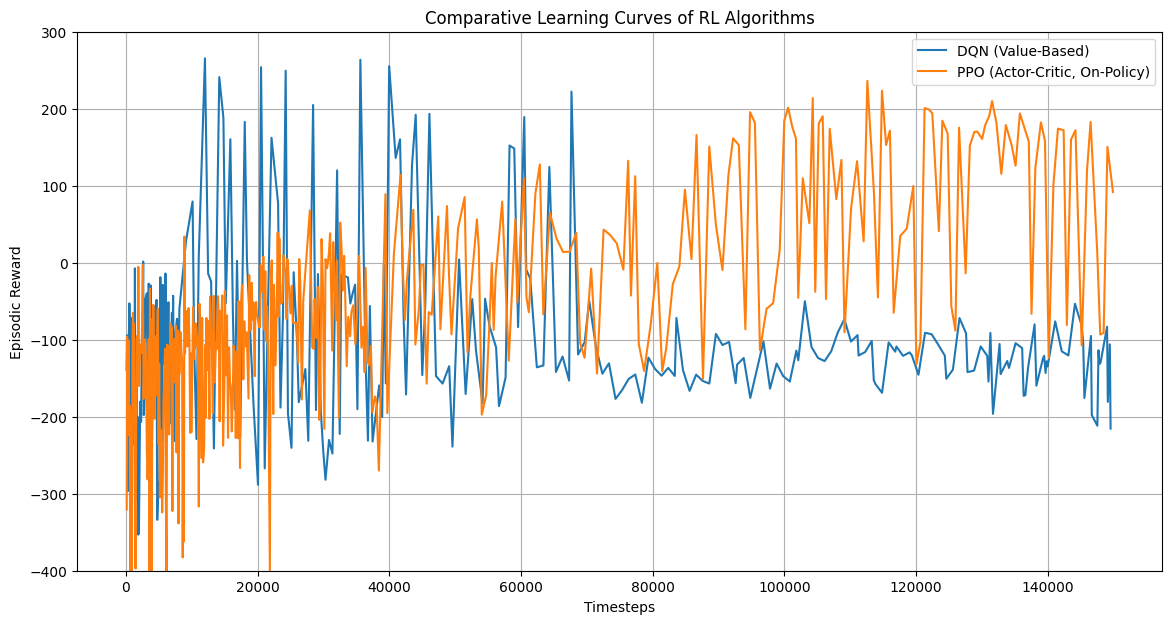

In [ ]:
# SCRIPT: COMPARATIVE ANALYSIS OF DQN AND PPO

import os
import gymnasium as gym
import torch
import stable_baselines3
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
import matplotlib.pyplot as plt
import numpy as np
import time

TOTAL_TIMESTEPS = 150000
SEED = 1
ENV_ID = 'LunarLander-v3'

# --- TRAINING FUNCTION ---
def train_and_evaluate(model_class, log_dir_path, policy_kwargs=None, custom_hyperparams={}):
    """Trains a model and records its training time."""
    os.makedirs(log_dir_path, exist_ok=True)
    env = gym.make(ENV_ID)
    env = Monitor(env, log_dir_path)

    model = model_class("MlpPolicy", env, seed=SEED, policy_kwargs=policy_kwargs, verbose=0, **custom_hyperparams)

    print(f"--- Starting Training for {model_class.__name__} ---")
    start_time = time.time()
    model.learn(total_timesteps=TOTAL_TIMESTEPS)
    end_time = time.time()

    training_time = end_time - start_time
    print(f"--- Training for {model_class.__name__} Complete ---")
    print(f"Compute Time: {training_time:.2f} seconds")

    env.close()
    return training_time

# 1. TRAIN EACH ALGORITHM

#DQN
dqn_log_dir = "./tmp/gym_dqn/"
dqn_hyperparams = {"learning_rate": 0.001, "buffer_size": 100000, "batch_size": 64, "gamma": 0.99}
dqn_policy_kwargs = dict(net_arch=[64, 64])
dqn_time = train_and_evaluate(DQN, dqn_log_dir, dqn_policy_kwargs, dqn_hyperparams)

#PPO
ppo_log_dir = "./tmp/gym_ppo/"
ppo_hyperparams = {"n_steps": 1024, "batch_size": 64, "n_epochs": 10, "gamma": 0.99, "gae_lambda": 0.95}
ppo_policy_kwargs = dict(net_arch=[64, 64])
ppo_time = train_and_evaluate(PPO, ppo_log_dir, ppo_policy_kwargs, ppo_hyperparams)

# 2. DOCUMENT RESULTS AND VISUALIZE

print("\n--- Experimentation Summary ---")
print(f"DQN Training Time: {dqn_time:.2f} s")
print(f"PPO Training Time: {ppo_time:.2f} s")
print("Reproducibility: Seed set to 1 for all runs.")
print("Libraries: Python 3.9+, PyTorch 1.12+, Gymnasium 0.26+, Stable-Baselines3 2.0+")

plt.figure(figsize=(14, 7))

# DQN
x_dqn, y_dqn = ts2xy(load_results(dqn_log_dir), 'timesteps')
plt.plot(x_dqn, y_dqn, label='DQN (Value-Based)')

# PPO
x_ppo, y_ppo = ts2xy(load_results(ppo_log_dir), 'timesteps')
plt.plot(x_ppo, y_ppo, label='PPO (Actor-Critic, On-Policy)')

# Plotting details
plt.title('Comparative Learning Curves of RL Algorithms')
plt.xlabel('Timesteps')
plt.ylabel('Episodic Reward')
plt.ylim([-400, 300])
plt.legend()
plt.grid(True)
plt.show()